# Arabidopsis Multi-Plant Tutorial

This is a fully-functioning workflow that demonstrates how to analyze the shape, size, and color of individual arabidopsis plants grown in a tray. Similar methods will work for other plant species and a tutorial that demonstrates several alternatives to the methods used here is available, see [Tools for Multi-Plant Analysis](../multi_plant_tutorial/multi_plant_tutorial.ipynb).


# Section 1: Importing Image and Libraries

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np
import os

## Input variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [3]:
class options:
    def __init__(self):
        self.image = "10.9.1.29_pos-153-001-003_2019-10-18-19-05.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "arabidopsis_results.txt"
        self.outdir = "."

In [4]:
# args holds the input variables
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

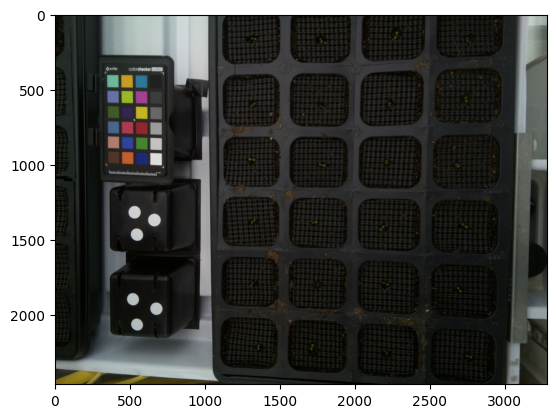

In [5]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 
#              'rgb', 'gray', 'csv', or 'envi'
in_img, path, filename = pcv.readimage(filename=args.image)

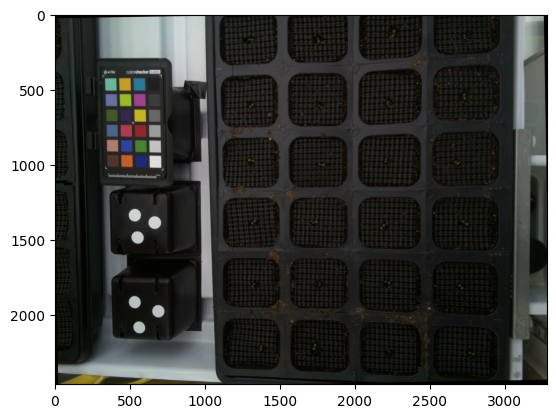

In [6]:
#change rotation degree value to rotate image so it's plants are straight (JMP)
img = pcv.transform.rotate(img=in_img, rotation_deg=1, crop=True)

# Section 2: Segmenting plant from background and identifying plant object(s)

* Requires successful import of image
* See the [Threshold Tools Tutorial](../threshold_tutorial/threshold.ipynb) for a full list of functions that can be used to create a binary mask

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces
and displays the grayscale channels in a matrix so that they can be
visualized simultaneously. The idea is to select a channel that maximizes
the difference between the plant and the background pixels.

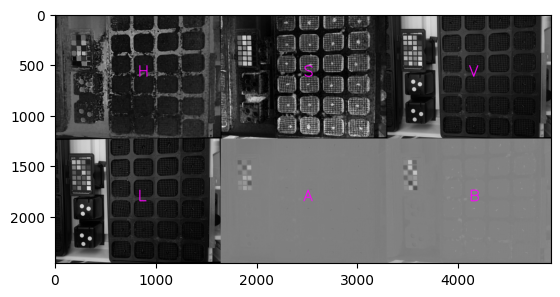

In [7]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to includ the RGB image in the display: 
#                  True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace
and returns the A (green-magenta) channel as a grayscale
image.

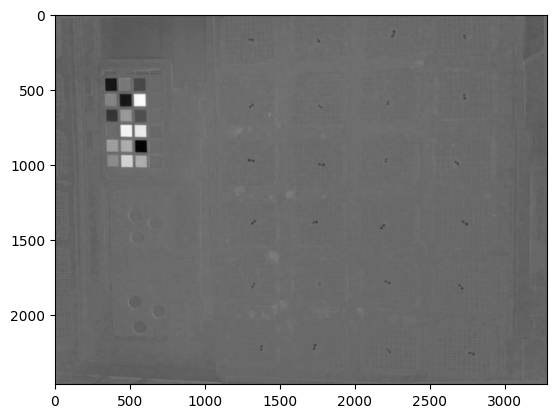

In [8]:
# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values
in an image. The histogram can aid in the selection of a
threshold value.

For this image, the large peak between 100-140 are from the
brighter background pixels. The smaller peak between 80-90
are the darker plant pixels.

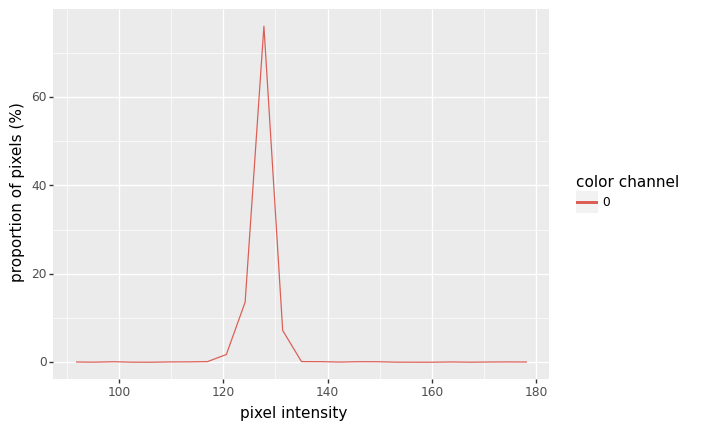

In [9]:
# Inputs:
#   img         = a color or grayscale image
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a, bins=25)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale
image into plant (white) and background (black) pixels. Using the
histogram above, a threshold point between 90-110 will segment the
plant and background peaks. Because the plants are the darker pixels
in this image, use `object_type="dark"` to do an inverse threshold.

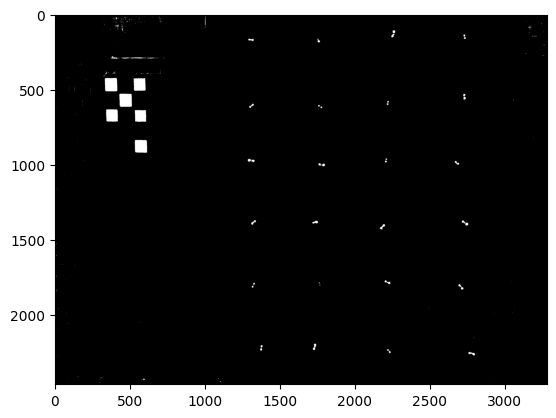

In [10]:
# Inputs:
#   gray_img    = grayscale image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = the value to assign for white pixels (typically 255)
#   object_type = 'dark' or 'light' depending on if plants are darker or lighter than background
a_thresh = pcv.threshold.binary(gray_img=a, threshold=120, max_value=255, object_type='dark')

## Remove small background noise

Thresholding mostly labeled plant pixels white but also labeled
small regions of the background white. The fill function removes
"salt" noise from the background by filtering white regions by size.

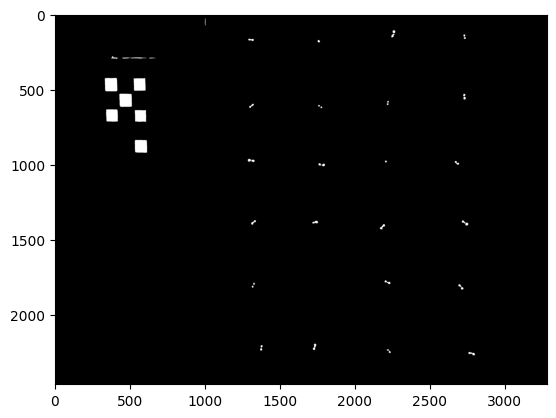

In [11]:
# Inputs:
#   bin_img = Binary image data
#   size    = minimum object area size in pixels (integer), smaller objects will be filled
a_fill = pcv.fill(bin_img=a_thresh, size=90)

# Section 3: Measure Individual Plants

* Need a completed binary mask

## Identify the outlines of all plants

The binary mask (all values are either white or black) that resulted
from thresholding and filtering the thresholded image is used to identify
the polygons that define the outlines of every connected white region.
Objects (or contours) can be nested, so a hierarchy that defines the
relationship between objects is also calculated.

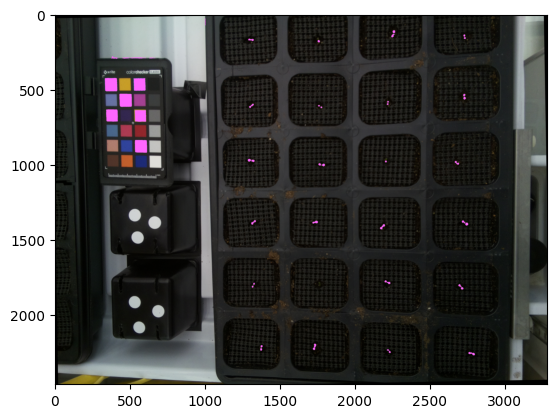

In [12]:
# Inputs:
#   img  = input image
#   mask = a binary mask used to detect objects
obj, obj_hierarchy = pcv.find_objects(img=img, mask=a_fill)

## Define a region of interest for each plant

Use the multi-ROI tool to define a region of interest (ROI) for each pot
in the tray. Each ROI will be associated with a plant later. The ROIs
do not need to completely contain a whole plant but must only overlap a
single plant each.

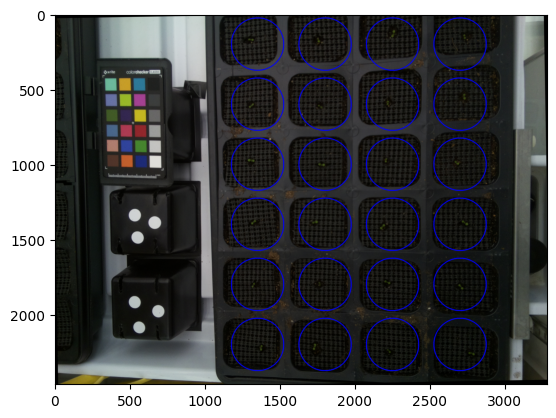

In [13]:
# Inputs:
#   img     = input image
#   coord   = top left coordinate to begin the ROI grid
#   radius  = radius for each ROI
#   spacing = spacing between each ROI
#   nrows   = number of rows in the ROI grid
#   ncols   = number of columns in the ROI grid
rois, roi_hierarchy = pcv.roi.multi(img=img, coord=(1350,200), radius=175, 
                                    spacing=(450, 400), nrows=6, ncols=4)

## Create a unique ID for each plant

Create a sequence of values to label each plant within the image
based on the ROI IDs.

In [14]:
# Inputs:
#   start = beginning value for range
#   stop  = ending value for range (exclusive)
plant_ids = range(0, len(rois))

## Measure each plant

To measure each plant, iterate over the ROIs so that only one region (pot)
is considered at a time. Within the loop, several steps are done:

1. Subset the ith ROI, the corresponding hierarchy, and the plant ID
2. Subset the objects found above that overlap the ith ROI
3. Consolidate the contours the define a single plant into one object (composition)
4. Analyze the plant shape and size characteristics

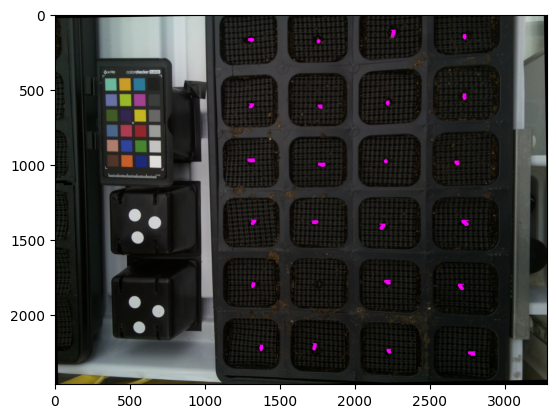

In [15]:
# Create a copy of the original image for annotations

# Inputs:
#   img = rgb image
img_copy = np.copy(img)

# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None

# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

    # If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        plant_obj, plant_mask = pcv.object_composition(img=img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)        
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant{plant_id}")

pcv.plot_image(img_copy)

## Save the results

During analysis, measurements are stored in the background in the `outputs` recorder.

This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object.

If other functions, for example color analysis, are desired, these should be included in the for loop.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [16]:
# Inputs:
#   filename  = filename for saving results, dont change args results here, change self results up top
#   outformat = output file format: "json" (default) hierarchical format
#                                   or "csv" tabular format
pcv.outputs.save_results(filename=args.result, outformat="csv")